DYN: Dynamic Mic version\
HSM: Headset Mic version\
LRX: Larynx Mic version\

我用的DYN， 就环境音小一点\
女高：DCS_LI_FullChoir_Take01_S1_LRX.wav\
男低：DCS_LI_FullChoir_Take01_B1_LRX.wav\

Load and preprocess data

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
audio_path = 'DagstuhlChoirSet_V1.2.3/audio_wav_22050_mono'
soprano_audio,soprano_sample_rate = librosa.load(audio_path+'/DCS_LI_FullChoir_Take01_S1_LRX.wav', sr=22050,mono=True)
bass_audio,bass_sample_rate = librosa.load(audio_path+'/DCS_LI_FullChoir_Take01_B1_LRX.wav', sr=22050,mono=True)

#print(soprano_audio.shape)
#print(soprano_sample_rate)
#print(bass_audio.shape)
#print(bass_sample_rate)

Spectrogram

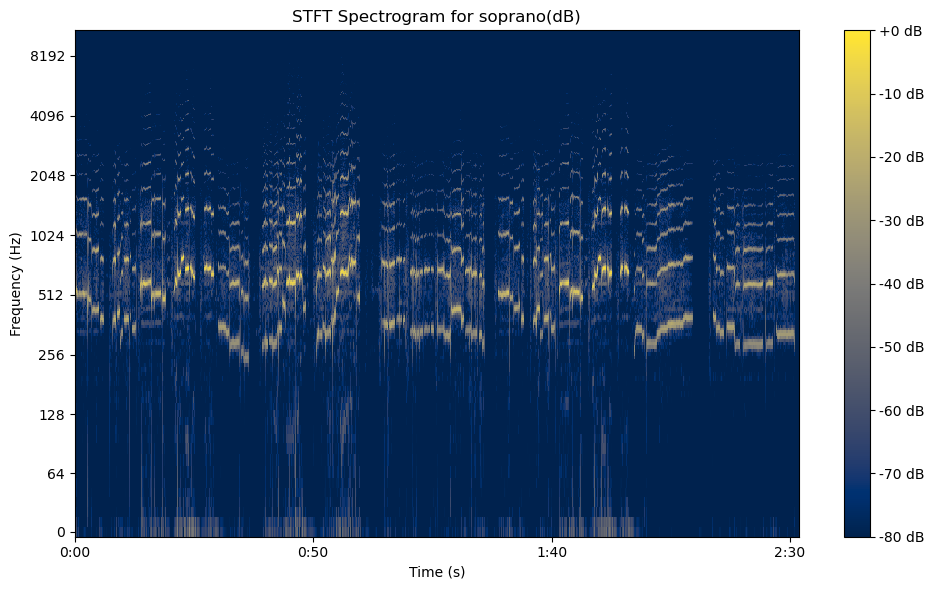

In [3]:
n_fft = 2048
hop_length = 512
soprano_stft = librosa.stft(soprano_audio, n_fft=n_fft, hop_length=hop_length)
soprano_spectrogram = np.abs(soprano_stft)
soprano_spectrogram_db = librosa.amplitude_to_db(soprano_spectrogram, ref=np.max)   

plt.figure(figsize=(10, 6))
librosa.display.specshow(soprano_spectrogram_db, sr=soprano_sample_rate, hop_length=hop_length, x_axis='time', y_axis='log',cmap='cividis')
plt.title('STFT Spectrogram for soprano(dB)')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

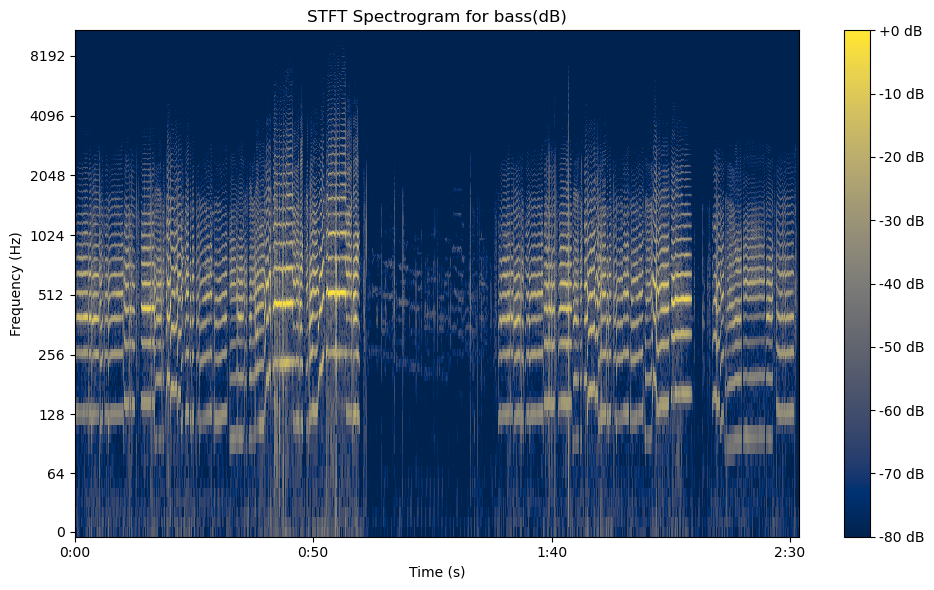

In [4]:
bass_stft = librosa.stft(bass_audio, n_fft=n_fft, hop_length=hop_length)
bass_spectrogram = np.abs(bass_stft)
bass_spectrogram_db = librosa.amplitude_to_db(bass_spectrogram, ref=np.max)   

plt.figure(figsize=(10, 6))
librosa.display.specshow(bass_spectrogram_db, sr=bass_sample_rate, hop_length=hop_length, x_axis='time', y_axis='log',cmap='cividis')
plt.title('STFT Spectrogram for bass(dB)')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

In [5]:
import torch 
import torch.nn as nn

class FreqFeatureExtractor(nn.Module):
    def __init__(self):
        super(FreqFeatureExtractor, self).__init__()
        self.cov1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.cov2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.pool = nn.MaxPool2d((2,2))
        
    def forward(self, x):
        x = self.pool(torch.relu(self.cov1(x)))
        x = self.pool(torch.relu(self.cov2(x)))
        x = x.view(x.size(0), -1)
        return x

In [6]:
soprano_spectrogram_tensor = torch.tensor(soprano_spectrogram).unsqueeze(0).unsqueeze(0)  
bass_spectrogram_tensor = torch.tensor(bass_spectrogram).unsqueeze(0).unsqueeze(0) 

print(soprano_spectrogram_tensor.shape)
print(bass_spectrogram_tensor.shape)

torch.Size([1, 1, 1025, 6541])
torch.Size([1, 1, 1025, 6541])


In [7]:
freq_feature_extractor = FreqFeatureExtractor()
soprano_freq_feature = freq_feature_extractor(soprano_spectrogram_tensor)
bass_freq_feature = freq_feature_extractor(bass_spectrogram_tensor)

print(soprano_freq_feature.shape)
print(bass_freq_feature.shape)

torch.Size([1, 13393920])
torch.Size([1, 13393920])


In [8]:
class TimeFeatureExtractor(nn.Module):
    def __init__(self):
        super(TimeFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        return x


In [9]:
time_feature_extractor = TimeFeatureExtractor()
soprano_audio_tensor = torch.tensor(soprano_audio).unsqueeze(0).unsqueeze(0)    
bass_audio_tensor = torch.tensor(bass_audio).unsqueeze(0).unsqueeze(0)
print(soprano_audio_tensor.shape)
print(bass_audio_tensor.shape)

torch.Size([1, 1, 3348564])
torch.Size([1, 1, 3348564])


In [10]:
soprano_time_features = time_feature_extractor(soprano_audio_tensor) 
bass_time_features = time_feature_extractor(bass_audio_tensor)

print(soprano_time_features.shape)
print(bass_time_features.shape)

torch.Size([1, 26788512])
torch.Size([1, 26788512])


In [11]:
soprano_combined_features = torch.cat((soprano_freq_feature, soprano_time_features), dim=1) 
bass_combined_features = torch.cat((bass_freq_feature, bass_time_features), dim=1)

print(soprano_combined_features.shape)
print(bass_combined_features.shape)


torch.Size([1, 40182432])
torch.Size([1, 40182432])


In [12]:
class FeatureFusion(nn.Module):
    def __init__(self, input_dim, output_dim=64):
        super(FeatureFusion, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self,x):
        fused_features = self.relu(self.fc(x))
        return fused_features


In [13]:
feature_fusion = FeatureFusion(input_dim = soprano_combined_features.shape[1])
soprano_fused_features = feature_fusion(soprano_combined_features)
bass_fused_features = feature_fusion(bass_combined_features)

print(soprano_fused_features.shape)
print(bass_fused_features.shape)


torch.Size([1, 64])
torch.Size([1, 64])


In [14]:
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim=1024):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.deconv1 = nn.ConvTranspose1d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)  # Fully connected layer
        x = x.unsqueeze(1)  # Reshape for deconvolution
        x = torch.relu(self.deconv1(x))
        x = torch.sigmoid(self.deconv2(x))  # Use sigmoid to ensure output is within [-1, 1]
        return x


In [15]:
soprano_decoder = Decoder(input_dim=soprano_fused_features.shape[1], output_dim=soprano_audio_tensor.shape[2])
bass_decoder = Decoder(input_dim=bass_fused_features.shape[1], output_dim=bass_audio_tensor.shape[2])
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(list(soprano_decoder.parameters()) + list(bass_decoder.parameters()), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()

    soprano_pred = soprano_decoder(soprano_fused_features)
    bass_pred = bass_decoder(bass_fused_features)

    soprano_loss = criterion(soprano_pred, soprano_audio_tensor)
    bass_loss = criterion(bass_pred, bass_audio_tensor)
    total_loss = soprano_loss + bass_loss

    total_loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {total_loss.item():.4f}")


RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1071540800 bytes.